In [1]:
import scanpy as sc
import numpy as np
import anndata as ad
import scanpy as sc
import igraph
import ALLCools
from ALLCools.integration.seurat_class import SeuratIntegration
import scanpy._utils as sc_utils 
import networkx as nx
import metis
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
import anndata
import os
from scipy.stats import zscore
import seaborn as sns

In [4]:
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import seaborn as sns
import scvelo as scv 

In [ ]:
#NR2_2

In [3]:
NR2_2= sc.read_h5ad('/mnt/f/spatial/NR2_2.h5ad')

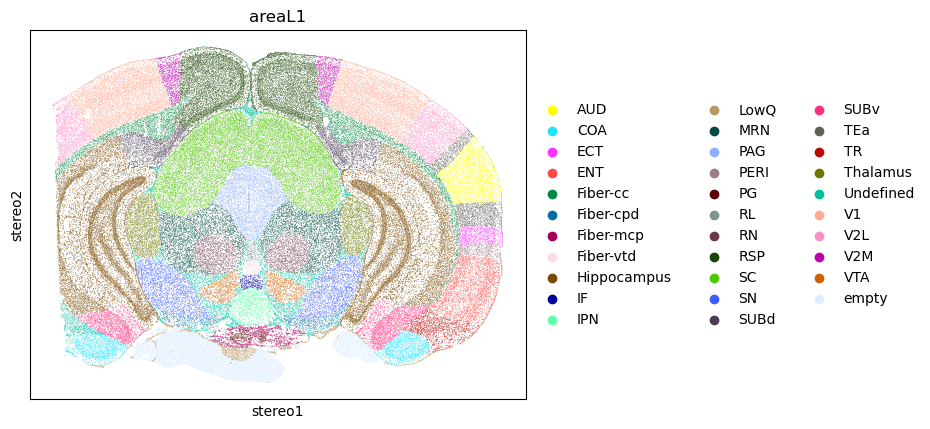

In [4]:
sc.pl.embedding(NR2_2, basis='stereo',color='areaL1')

In [5]:
NR2_2_V1 = NR2_2[NR2_2.obs['areaL1']=='V1']

In [6]:
NR2_2_V1R = NR2_2_V1[NR2_2_V1.obs['left_right']=='right']

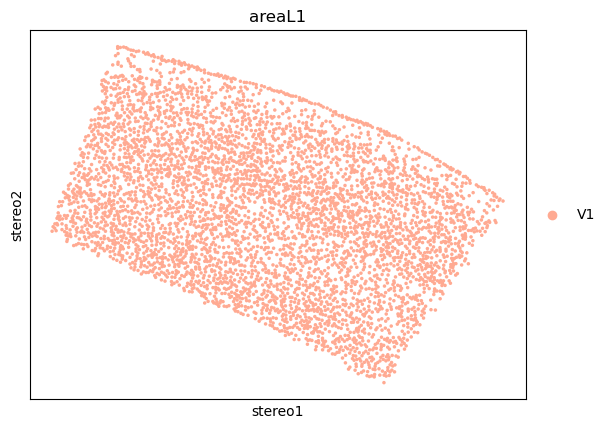

In [7]:
sc.pl.embedding(NR2_2_V1R, basis='stereo',color='areaL1')

In [8]:
N_V1_Sn = sc.read_h5ad('/mnt/f/RNA_velocity/V1/NR_V1_ann_filter.h5ad')

In [9]:
# Consider the common genes
common_genes = np.array(N_V1_Sn.var_names.intersection(NR2_2_V1R.var_names))

In [10]:
def get_sparse_from_igraph(graph, weight_attr=None):
    from scipy.sparse import csr_matrix

    edges = graph.get_edgelist()
    if weight_attr is None:
        weights = [1] * len(edges)
    else:
        weights = graph.es[weight_attr]
    if not graph.is_directed():
        edges.extend([(v, u) for u, v in edges])
        weights.extend(weights)
    shape = graph.vcount()
    shape = (shape, shape)
    if len(edges) > 0:
        return csr_matrix((weights, zip(*edges)), shape=shape)
    else:
        return csr_matrix(shape)

In [11]:
def partition_subclasses(adata, n_partitions):
    '''Assign integration partitions as the adata.obs['integration_partion'] column.'''
    adata.obs['integration_partition'] = 'p0'
    
    # Get a sparse matrix of that counts edges between subclasses
    ones = adata.obsp['distances'].copy()
    ones.data = np.ones(len(ones.data))

    g_neighobrs = sc._utils.get_igraph_from_adjacency(ones, directed=True)
    vc = igraph.VertexClustering(g_neighobrs, membership=adata.obs['Subclass'].cat.codes.values)
    cluster_mtx = get_sparse_from_igraph(vc.cluster_graph(combine_edges='sum'), weight_attr='weight')
    
    # Partition the cluster level graph
    G_cluster = nx.from_scipy_sparse_array(cluster_mtx)
    for i in adata.obs['Subclass'].cat.codes.values:
        G_cluster.nodes[i]['weight'] = np.sum(adata.obs['Subclass'] 
                                              == adata.obs['Subclass'].cat.categories[i] )
    G_cluster.graph['node_weight_attr'] = 'weight'
    
    (cut, parts) = metis.part_graph(G_cluster, n_partitions, recursive=False,
                                   tpwgts=[1 / n_partitions] * n_partitions) 
    
    # Assign the partitions
    for i in range(len(parts)):
        mask = (adata.obs['Subclass'] == adata.obs['Subclass'].cat.categories[i])
        adata.obs.loc[mask, 'integration_partition'] = 'p' + str(parts[i])
    
    adata.obs['integration_partition'] = adata.obs['integration_partition'].astype('category')
    
import scipy.sparse
def get_cluster_mean_expression_matrix(adata, cluster_column):
    '''Get a dataframe of mean gene expression of each cluster.'''
    if scipy.sparse.issparse(adata.X):
        X = adata.X.toarray()
    else:
        X = adata.X
   
    cell_exp_mtx = pd.DataFrame(X, index=adata.obs[cluster_column], columns=adata.var.index)    
    return cell_exp_mtx.groupby(by=cluster_column).mean()

def calculate_correlation_matrix(adata, cluster_column):
    '''Calculate gene expression correlations between clusters.'''
    cluster_mean_exp = get_cluster_mean_expression_matrix(adata, cluster_column)
    
    # Initialzie the correlation matrix
    cluster_ids = np.array(cluster_mean_exp.index)
    N_clusters = len(cluster_ids)
    correlation_mtx = pd.DataFrame(np.ones((N_clusters, N_clusters)), index=cluster_ids, columns=cluster_ids)
    
    # Fill the correlation matrix
    for i in range(N_clusters):
        cluster_id1 = cluster_ids[i]
        mean_exps1 = np.array(cluster_mean_exp.loc[cluster_id1])
        
        for j in range(i + 1, N_clusters):
            cluster_id2 = cluster_ids[j]
            mean_exps2 = np.array(cluster_mean_exp.loc[cluster_id2])
            
            r, p = scipy.stats.pearsonr(mean_exps1, mean_exps2)

            correlation_mtx.loc[cluster_id1, cluster_id2] = r
            correlation_mtx.loc[cluster_id2, cluster_id1] = r
            
    return correlation_mtx

def merge_clusters(obs_df, cluster_col, clusters_to_merge):
    merged_cluster_id = sorted(clusters_to_merge)[0]
    obs_df[cluster_col][obs_df[cluster_col].isin(clusters_to_merge)] = merged_cluster_id
    obs_df[cluster_col] = obs_df[cluster_col].cat.remove_unused_categories()

In [12]:
%%time
# Define the integration partitions using the sequencing data
n_partitions = 250

# 标准化并检查数据
sc.pp.normalize_total(N_V1_Sn, target_sum=1000)


# 对数转换并检查数据
sc.pp.log1p(N_V1_Sn)


# 缩放并防止除以零的情况
sc.pp.scale(N_V1_Sn, zero_center=False)


# PCA降维
n_pcs = 100
sc.tl.pca(N_V1_Sn, svd_solver='arpack', n_comps=n_pcs)


# 计算neighbors
sc.pp.neighbors(N_V1_Sn, use_rep='X_pca', n_neighbors=25, n_pcs=n_pcs)

# 分区并进行整合
partition_subclasses(N_V1_Sn, n_partitions)

# 后续的分区合并和处理
partition_corr_df = calculate_correlation_matrix(N_V1_Sn, 'integration_partition')
p_names, p_n_cells = np.unique(N_V1_Sn.obs['integration_partition'], return_counts=True)
p_smalls = p_names[p_n_cells < 10000]
p_larges = p_names[p_n_cells >= 10000]
partition_corr_df = partition_corr_df.loc[p_smalls, p_larges]

for p1 in p_smalls:
    # 检查 partition_corr_df.loc[p1] 是否为空
    if partition_corr_df.loc[p1].empty:
        print(f"Warning: partition {p1} has no corresponding large partition.")
        continue  # 跳过这个空的序列
    
    # 继续进行合并
    p2 = partition_corr_df.columns[np.argmax(partition_corr_df.loc[p1])]
    print(f'Merge partitions {p1} and {p2}')
    merge_clusters(N_V1_Sn.obs, 'integration_partition', [p1, p2])

seq_annotation_df = N_V1_Sn.obs.copy()


	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to

/tmp/ipykernel_242522/4169816286.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return cell_exp_mtx.groupby(by=cluster_column).mean()


CPU times: user 1min 3s, sys: 2.14 s, total: 1min 6s
Wall time: 22.5 s


In [13]:
%%time
# Reload the sequencing data and assign the partitions
N_V1_Sn.obs['integration_partition'] = seq_annotation_df['integration_partition']

N_V1_Sn.obs['Subclass'] = N_V1_Sn.obs['Subclass'].astype('category')
N_V1_Sn.obs['Type'] = N_V1_Sn.obs['Type'].astype('category')

N_V1_Sn = N_V1_Sn[~N_V1_Sn.obs['Type'].isna()]
N_V1_Sn = N_V1_Sn[~N_V1_Sn.obs['Subclass'].isna()]

CPU times: user 109 ms, sys: 30 ms, total: 139 ms
Wall time: 138 ms


In [14]:
%%time
# Split the sequencing data for the input of the final round of integration.
# Because imputation is done at this round, all genes are included.

partition_path = '/mnt/f/spatial/V1_integration/NR2_2/partitions/'

# 获取分区信息
partitions = N_V1_Sn.obs['integration_partition'].cat.categories

print('Partition, N_cells, subclasses')

# 遍历每个分区
for pn in partitions:
    # 根据分区选择子集数据
    adata_subset = N_V1_Sn[N_V1_Sn.obs['integration_partition'] == pn]
    
    # 替换路径中的不合法字符并生成保存路径
    partition_save_path = partition_path + pn.replace('/', '-').replace(' ', '_') + '/'
    
    # 自动创建目标文件夹，如果不存在则创建
    os.makedirs(partition_save_path, exist_ok=True)
    
    # 将子集数据保存到 .h5ad 文件
    save_file = partition_save_path + 'adata_seq.h5ad'
    adata_subset.write_h5ad(save_file, compression='gzip')
    
    # 打印分区的统计信息
    print(f'{pn}, {adata_subset.shape[0]}, {list(np.unique(adata_subset.obs["Subclass"]))}')


Partition, N_cells, subclasses
p108, 1597, ['L6 CT CTX']
p124, 1025, ['Oligo']
p155, 3044, ['L4/5 IT CTX']
p186, 631, ['L5 IT CTX']
p201, 860, ['L6 IT CTX']
p205, 213, ['Microglia']
p209, 279, ['OPC']
p217, 674, ['Astro']
p225, 307, ['Lamp5']
p229, 632, ['Sst']
p233, 238, ['L5 NP CTX']
p237, 420, ['Vip']
p239, 207, ['L6b CTX']
p240, 34, ['ABC']
p241, 16, ['VLMC']
p249, 553, ['Pvalb']
p61, 3376, ['L2/3 IT CTX']
p92, 1459, ['L5 ET CTX']
CPU times: user 15 s, sys: 226 ms, total: 15.2 s
Wall time: 26 s


In [93]:
# Merge the datasets
NR_V1_merge = N_V1_Sn.concatenate(NR2_2_V1R,
                                    batch_categories=['seq', 'spatial'],
                                    batch_key='modality',
                                    index_unique=None,join='outer')

/tmp/ipykernel_242522/3510182836.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  NR_V1_merge = N_V1_Sn.concatenate(NR2_2_V1R,
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [94]:
%%time
# Get the significant PCs
n_pcs = 11
sc.tl.pca(NR_V1_merge, svd_solver='arpack', n_comps=11)

CPU times: user 32.8 s, sys: 367 ms, total: 33.1 s
Wall time: 2.91 s


In [95]:
NR_V1_list = [NR_V1_merge[NR_V1_merge.obs['modality'] == 'seq'],
              NR_V1_merge[NR_V1_merge.obs['modality'] == 'spatial']]

In [96]:
%%time
# Find the integration anchors
integrator = SeuratIntegration()
integrator.find_anchor(NR_V1_list,
                       k_local=None,
                       key_local='X_pca',
                       k_anchor=50,
                       key_anchor='X',
                       dim_red='cca',
                       max_cc_cells=100000,
                       k_score=100,
                       k_filter=None,
                       scale1=False,
                       scale2=False,
                       n_components=n_pcs,
                       n_features=200,
                       alignments=[[[0], [1]]])

Find anchors across datasets.
Run CCA
non zero dims 11
Find Anchors using k=100
Score Anchors
Identified 152971 anchors between datasets 0 and 1.
CPU times: user 2min 52s, sys: 11.2 s, total: 3min 4s
Wall time: 27.7 s


In [97]:
#label transfer
cell_type_col = 'integration_partition'

transfer_results = integrator.label_transfer(
    ref=[0],
    qry=[1],
    categorical_key=[cell_type_col],
    key_dist='X_pca',
    k_weight=100,
    npc=n_pcs)

integrator.save_transfer_results_to_adata(NR_V1_merge, transfer_results)

Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer


In [98]:
# Assign the transfered labels and the confidence
NR2_2_V1R.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1).astype('category')
NR2_2_V1R.obs[cell_type_col + '_confidence'] = transfer_results[cell_type_col].max(axis=1)

n_transfered = len(np.unique(NR2_2_V1R.obs[cell_type_col + '_transfer']))
n_total = len(np.unique(NR_V1_merge.obs[cell_type_col + '_transfer']))
print(f'Transfered {n_transfered}/{n_total} cell types.')

Transfered 17/18 cell types.


In [99]:
# Save the label transfer results for each class
partition_path = '/mnt/f/spatial/V1_integration/NR2_2/partitions/'


partitions = NR2_2_V1R.obs[cell_type_col + '_transfer'].unique()

cell_type_col = 'integration_partition'

for pn in partitions:

    adata_subset =NR2_2_V1R[NR2_2_V1R.obs[cell_type_col + '_transfer'] == pn]
    

    partition_save_path = partition_path + pn.replace('/', '-').replace(' ', '_') + '/'
    

    if not os.path.exists(partition_save_path):
        os.makedirs(partition_save_path, exist_ok=True)
    

    save_file = partition_save_path + 'adata_spatial_integrated.h5ad'
    

    adata_subset.write_h5ad(save_file, compression='gzip')
    

    print(f'Successfully saved for partition {pn} at: {save_file}')


Successfully saved for partition p124 at: /mnt/f/spatial/V1_integration/NR2_2/partitions/p124/adata_spatial_integrated.h5ad
Successfully saved for partition p201 at: /mnt/f/spatial/V1_integration/NR2_2/partitions/p201/adata_spatial_integrated.h5ad
Successfully saved for partition p239 at: /mnt/f/spatial/V1_integration/NR2_2/partitions/p239/adata_spatial_integrated.h5ad
Successfully saved for partition p217 at: /mnt/f/spatial/V1_integration/NR2_2/partitions/p217/adata_spatial_integrated.h5ad
Successfully saved for partition p61 at: /mnt/f/spatial/V1_integration/NR2_2/partitions/p61/adata_spatial_integrated.h5ad
Successfully saved for partition p108 at: /mnt/f/spatial/V1_integration/NR2_2/partitions/p108/adata_spatial_integrated.h5ad
Successfully saved for partition p205 at: /mnt/f/spatial/V1_integration/NR2_2/partitions/p205/adata_spatial_integrated.h5ad
Successfully saved for partition p92 at: /mnt/f/spatial/V1_integration/NR2_2/partitions/p92/adata_spatial_integrated.h5ad
Successfully

In [100]:
%%time
# Correct the PCs using the integration anchors
corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=n_pcs,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

NR_V1_merge.obsm['X_pca_integrate'] = np.concatenate(corrected)

Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data
CPU times: user 9min 52s, sys: 1min 20s, total: 11min 12s
Wall time: 1min 16s


In [101]:
# Calculate KNN using the integrated PCs
sc.pp.neighbors(NR_V1_merge,use_rep='X_pca_integrate')

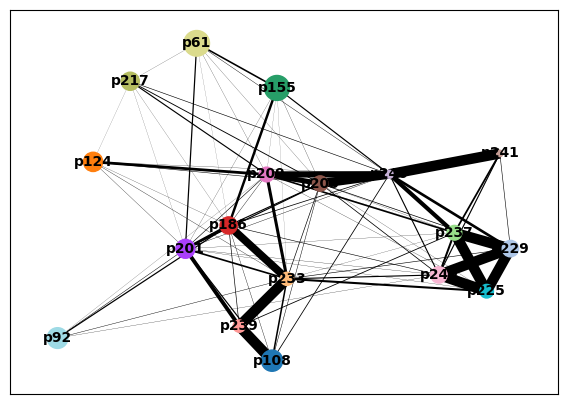

CPU times: user 583 ms, sys: 8.69 ms, total: 592 ms
Wall time: 600 ms


In [102]:
%%time
# Generate the PAGA plot for the initial arrangement of the UMAP
sc.tl.paga(NR_V1_merge, groups=cell_type_col + '_transfer')
sc.pl.paga(NR_V1_merge, save='_tmp.png')

In [40]:
Partition, N_cells, subclasses
p108, 1597, ['L6 CT CTX']
p124, 1025, ['Oligo']
p155, 3044, ['L4/5 IT CTX']
p186, 631, ['L5 IT CTX']
p201, 860, ['L6 IT CTX']
p205, 213, ['Microglia']
p209, 279, ['OPC']
p217, 674, ['Astro']
p225, 307, ['Lamp5']
p229, 632, ['Sst']
p233, 238, ['L5 NP CTX']
p237, 420, ['Vip']
p239, 207, ['L6b CTX']
p240, 34, ['ABC']
p241, 16, ['VLMC']
p249, 553, ['Pvalb']
p61, 3376, ['L2/3 IT CTX']
p92, 1459, ['L5 ET CTX']
CPU times: user 15 s, sys: 226 ms, total: 15.2 s
Wall time: 26 s

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4074823444.py, line 20)

In [103]:
subclass_dict={'p108':'L6 CT CTX',
'p209':'OPC',
'p92' :'L5 ET CTX',
'p186' :'L5 IT CTX',
'p201' :'L6 IT CTX',
'p237' :'Vip',
'p225' :'Lamp5',
'p233' :'L5 NP CTX',
'p205' :'Microglia',
'p239' :'L6b CTX',
'p241' :'VLMC',
'p240' :'ABC',
'p229' :'Sst',
'p217' :'Astro',
'p249' :'Pvalb',
'p61'  :'L2/3 IT CTX',
'p155'  :'L4/5 IT CTX',
'p124'  :'Oligo'}

In [104]:
NR_V1_merge.obs['integration_subclass_transfer'] = NR_V1_merge.obs['integration_partition_transfer'].map(subclass_dict)
print(NR_V1_merge.obs[['integration_partition_transfer', 'integration_subclass_transfer']])

                         integration_partition_transfer  \
AAACCCAAGTACTGTC-1-V1_N1                           p249   
AAACCCAAGTTGGAAT-1-V1_N1                           p186   
AAACCCACAGAAATTG-1-V1_N1                           p217   
AAACCCACATACCAGT-1-V1_N1                           p155   
AAACCCAGTCTACATG-1-V1_N1                            p92   
...                                                 ...   
105251                                             p209   
105252                                             p205   
105253                                             p209   
106647                                             p205   
106650                                             p205   

                         integration_subclass_transfer  
AAACCCAAGTACTGTC-1-V1_N1                         Pvalb  
AAACCCAAGTTGGAAT-1-V1_N1                     L5 IT CTX  
AAACCCACAGAAATTG-1-V1_N1                         Astro  
AAACCCACATACCAGT-1-V1_N1                   L4/5 IT CTX  
AAACCC

In [105]:
NR_V1_merge

AnnData object with n_obs × n_vars = 20251 × 27491
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Class', 'preclass', 'cluster', 'Subclass', 'Sample', 'Type', 'Subtype', 'Cell_annotation', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'modality', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V1_N1-seq', 'highly_variable-V1_N1-seq', 'means-V1_N1-seq', 'dispersions-V1_N1-seq', 'dispersions_norm-V1_N1-seq', 'n_cells-V1_N2-seq', 'highly_variable-V1_N2-seq', 'means-V1_N2-seq', 'dispersions-V1_N2-seq', 'dispersions_norm-V1_N2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'paga', 'integration_partition_transfer_sizes', 'integration_partition_transfer_

In [108]:
coembedding_umap_df = NR_V1_merge.obs[[]].copy()
coembedding_umap_df['umap_x'] = NR_V1_merge.obsm['X_umap'][:, 0]
coembedding_umap_df['umap_y'] = NR_V1_merge.obsm['X_umap'][:, 1]
coembedding_umap_df.to_csv('coembedding_umap.csv')

In [ ]:
#Integrate individual partitions

In [109]:
def impute_gene_expression(integrator, adata_list, X_ref, ref=0, qry=1, npc=30, k_weight=30, sd=1,
                           chunk_size=1000, random_state=0):
    data_qry = adata_list[qry].obsm['X_pca']

    anchor, G, D, cum_qry = integrator.find_nearest_anchor(adata_list, data_qry=data_qry, ref=[ref], qry=[qry],
                                                      npc=npc, k_weight=k_weight, sd=sd, random_state=random_state)
    
    if scipy.sparse.issparse(X_ref):
        X_ref = X_ref.toarray()
    
    X_anchor = X_ref[anchor[:, 0]]
    imputed_chunks = []
    
    for chunk_start in np.arange(0, data_qry.shape[0], chunk_size):
        imputed_chunks.append(scipy.sparse.csr_matrix((
                        D[chunk_start:(chunk_start + chunk_size), :, None] *
                        X_anchor[G[chunk_start:(chunk_start + chunk_size)]]
                    ).sum(axis=1).astype(np.float32)))

    return scipy.sparse.vstack(imputed_chunks)

Integrating for partition p108


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 11820 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 2/3 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 394 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


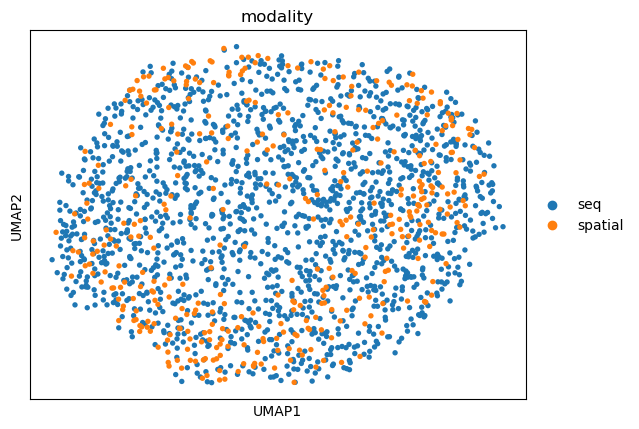

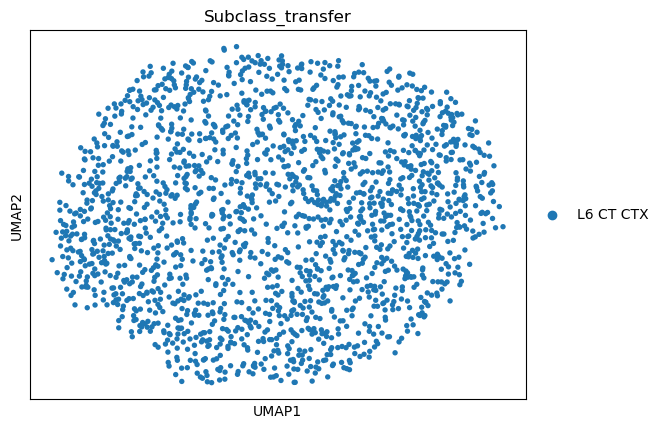

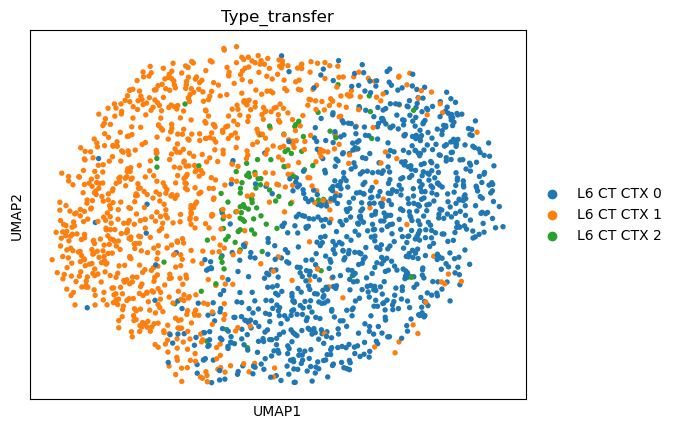

Integrating for partition p124


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 9929 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 2/2 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 331 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


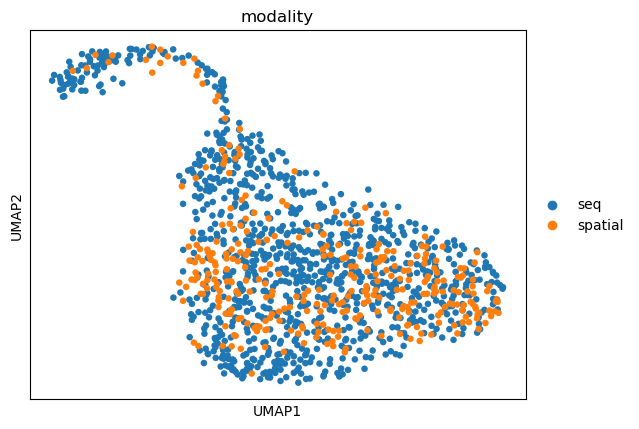

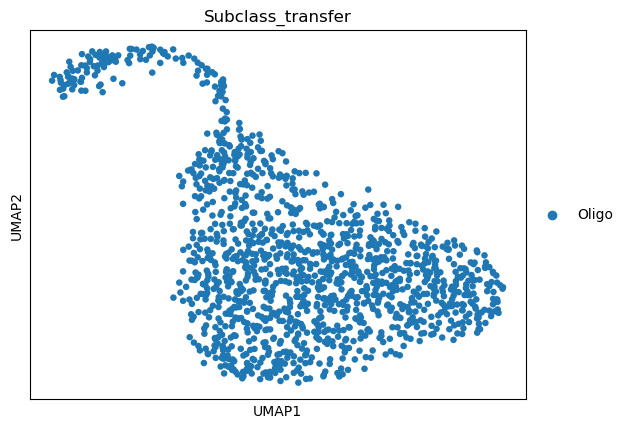

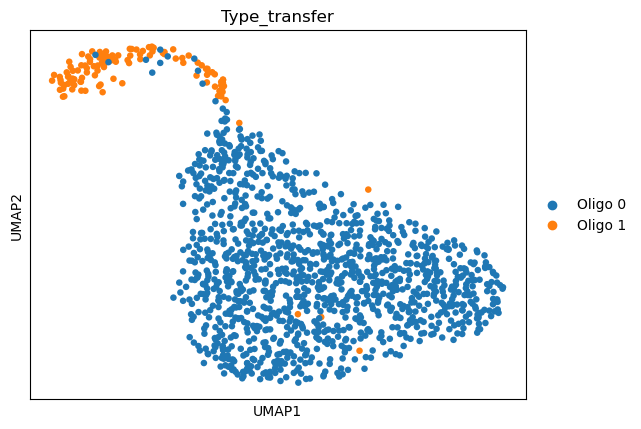

Integrating for partition p155


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 23278 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 2/2 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 776 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


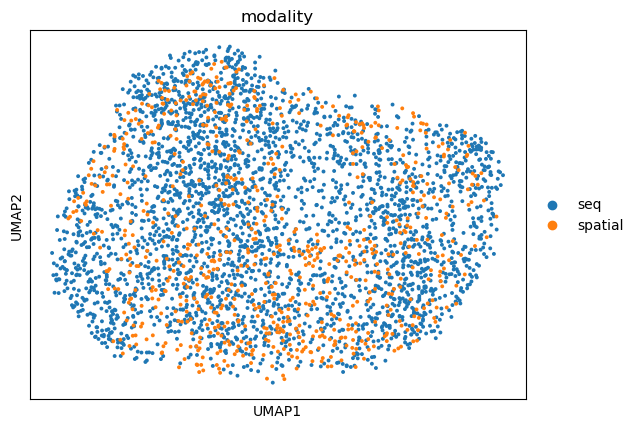

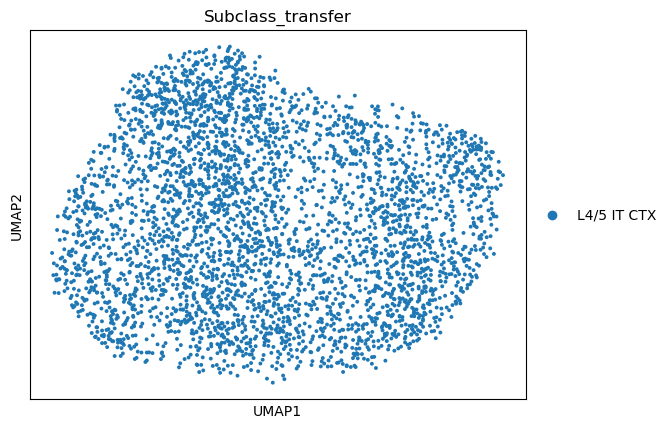

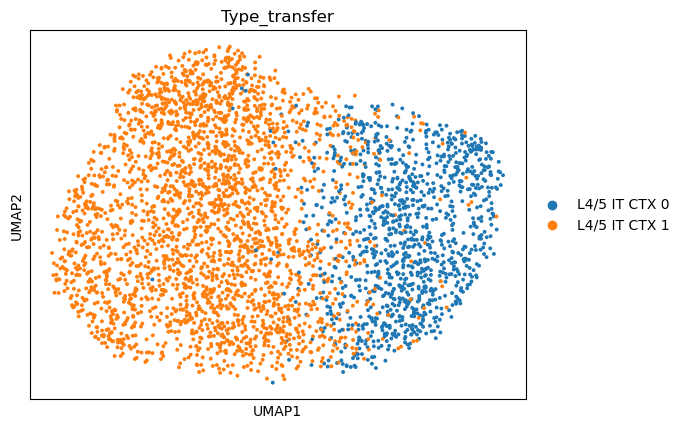

Integrating for partition p186


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 6930 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 2/2 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 231 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


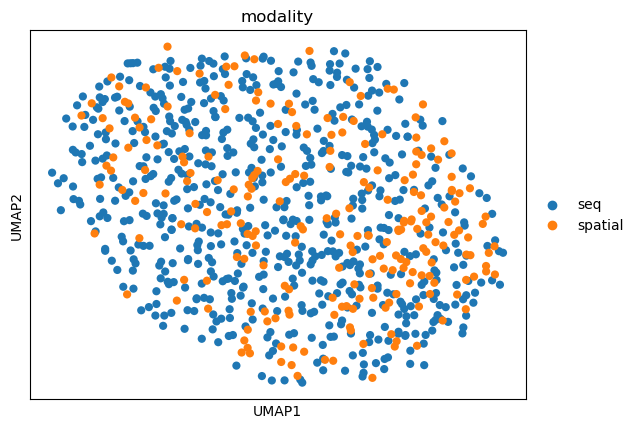

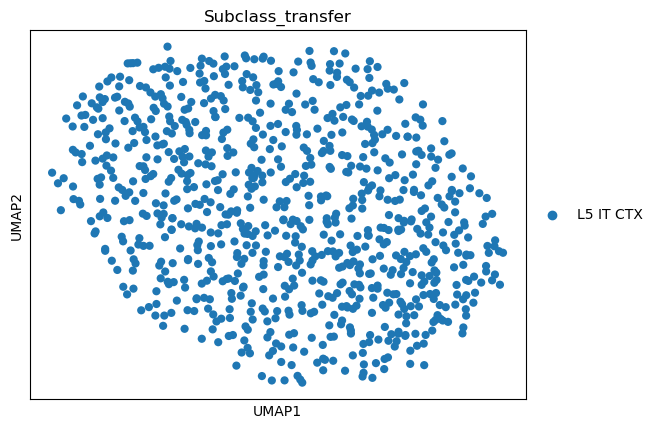

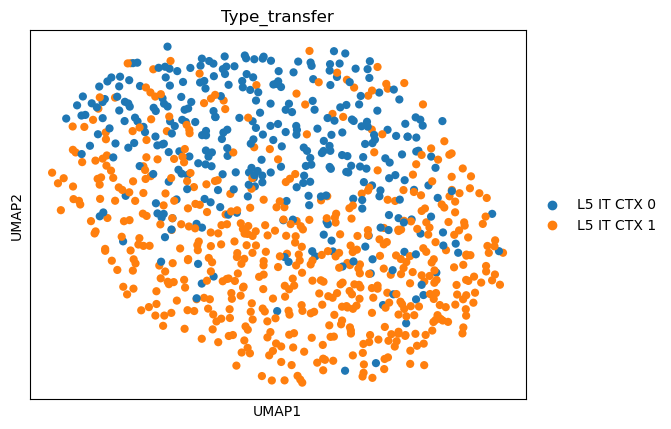

Integrating for partition p201


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 11999 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 2/3 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 400 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


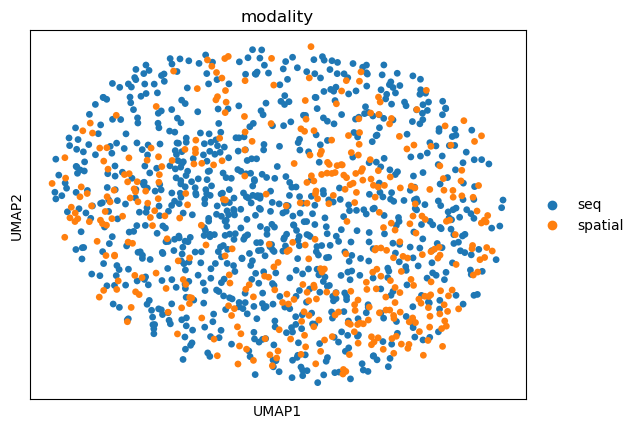

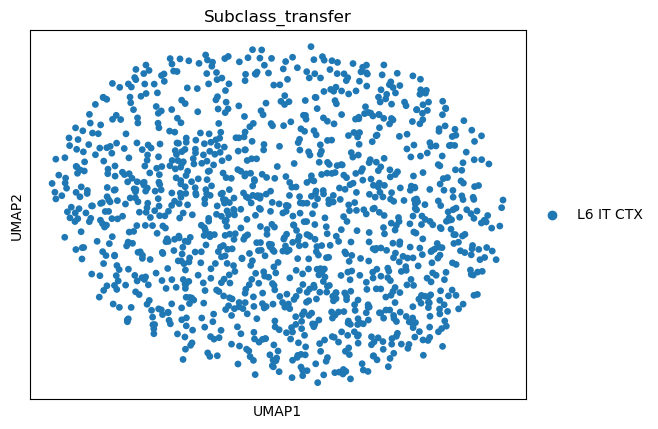

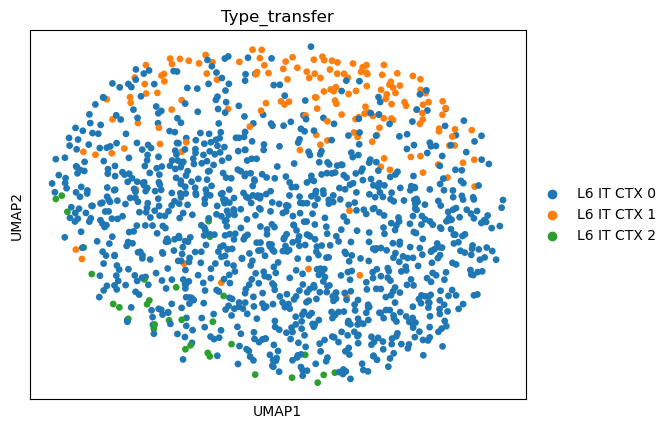

Integrating for partition p205


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 6390 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 341 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


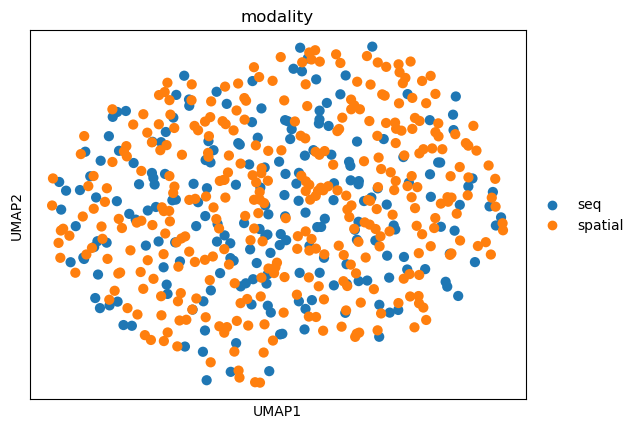

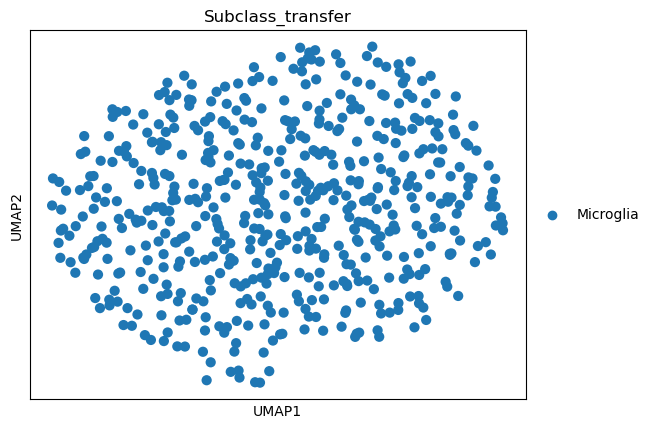

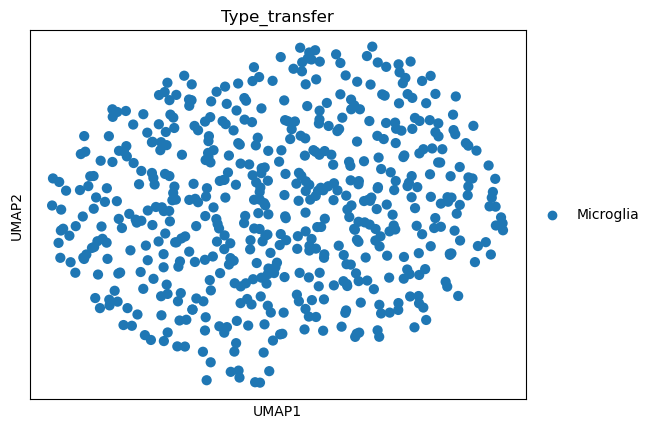

Integrating for partition p209


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 5412 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 181 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


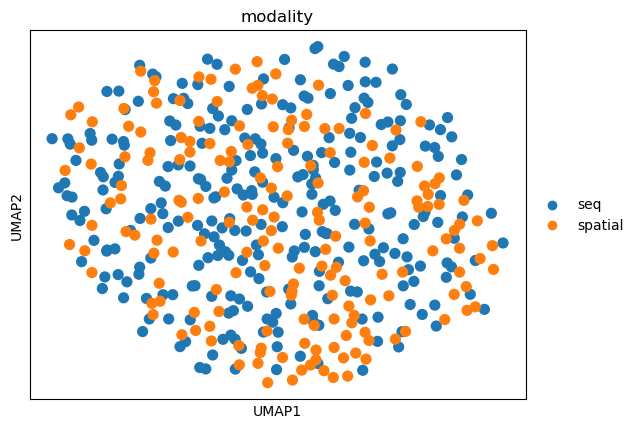

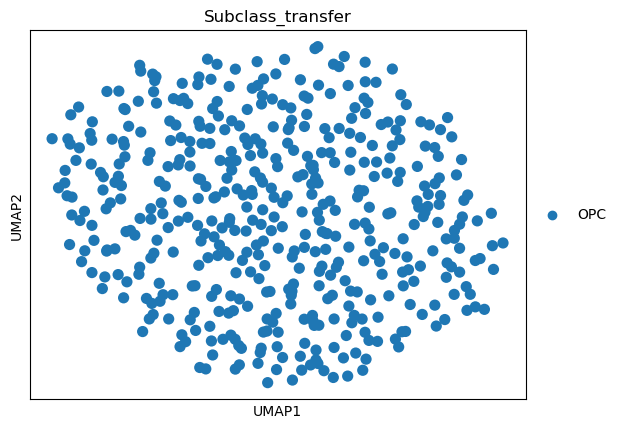

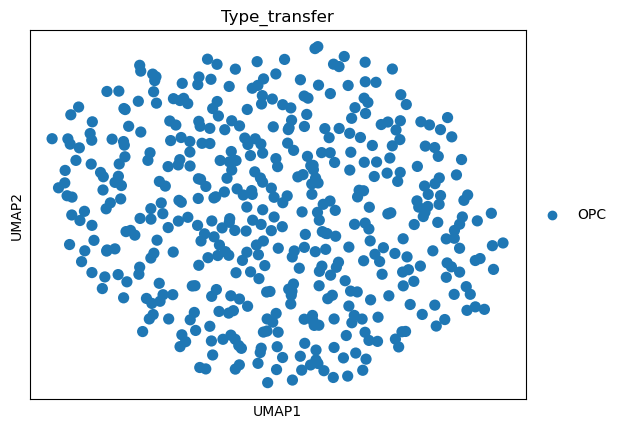

Integrating for partition p217


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 11698 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 391 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


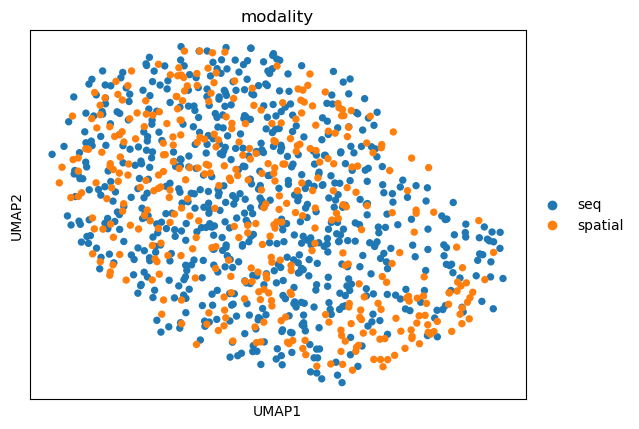

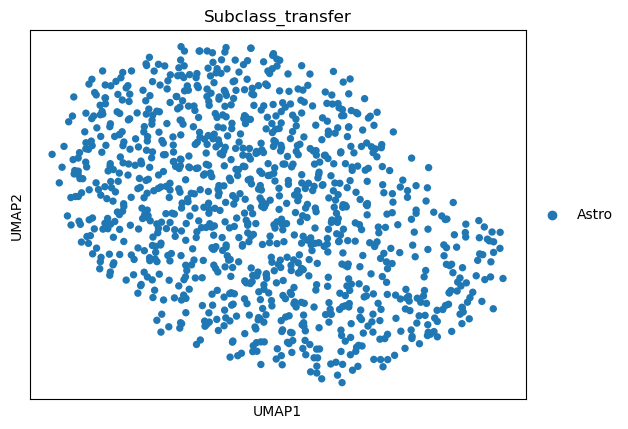

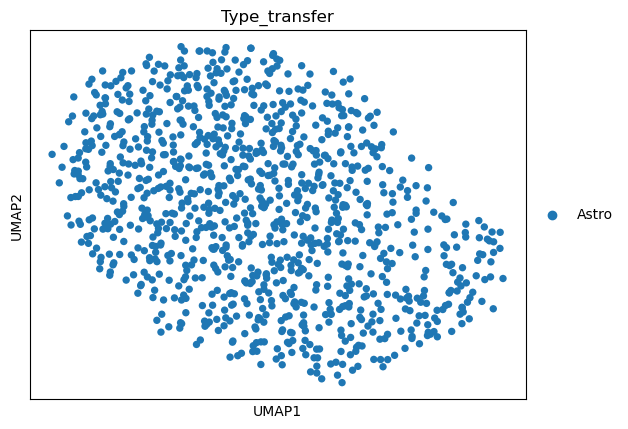

Integrating for partition p229


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=92
Score Anchors
Identified 2820 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 3/4 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 94 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


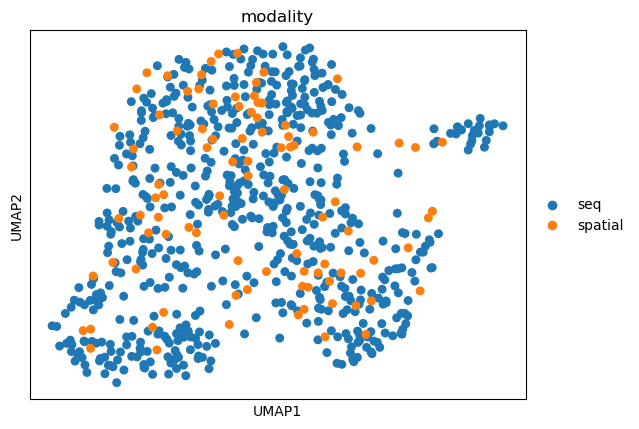

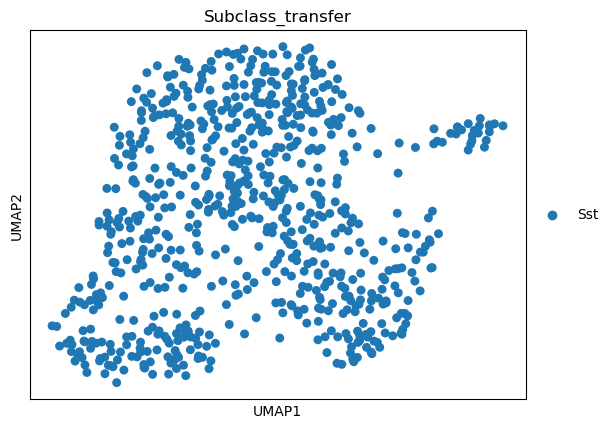

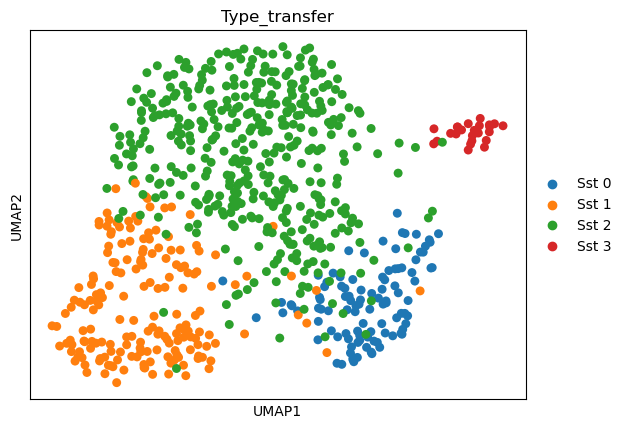

Integrating for partition p233


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=53
Score Anchors
Identified 1650 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 55 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


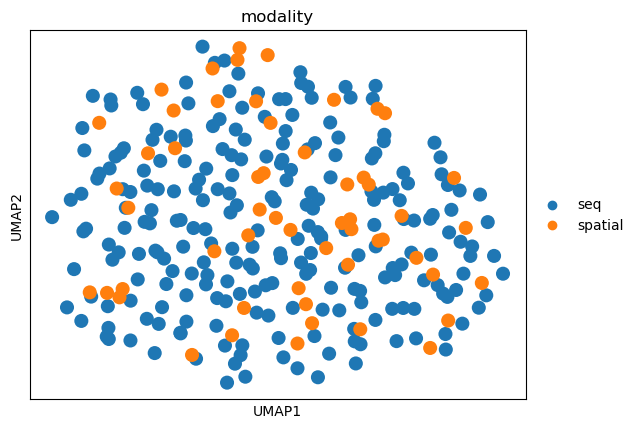

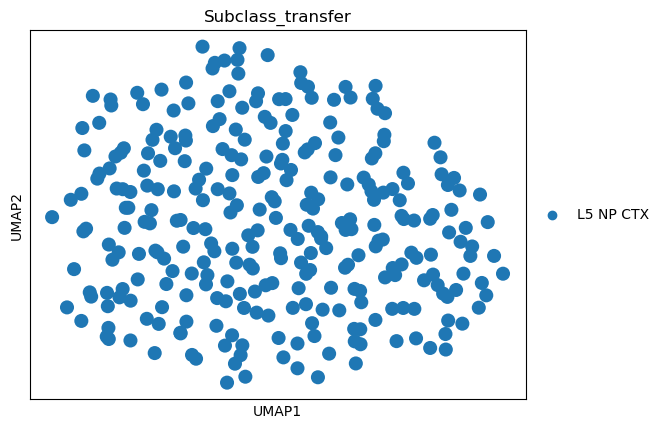

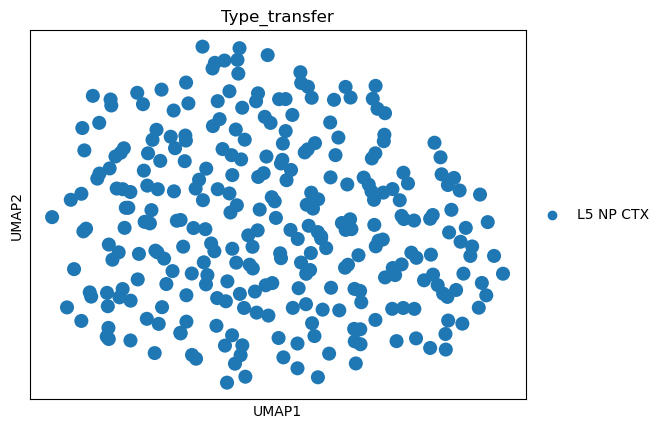

Integrating for partition p237


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=41
Score Anchors
Identified 1290 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 43 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


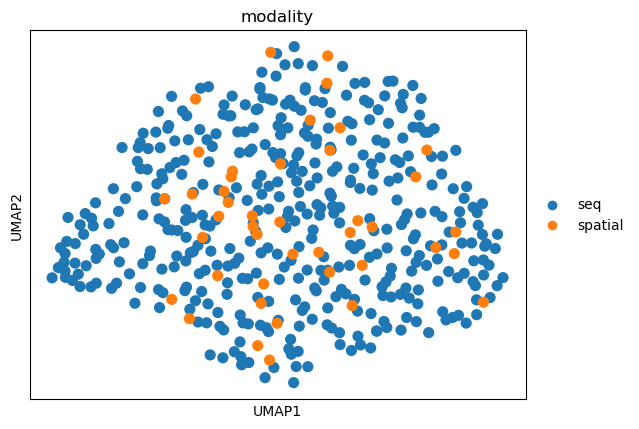

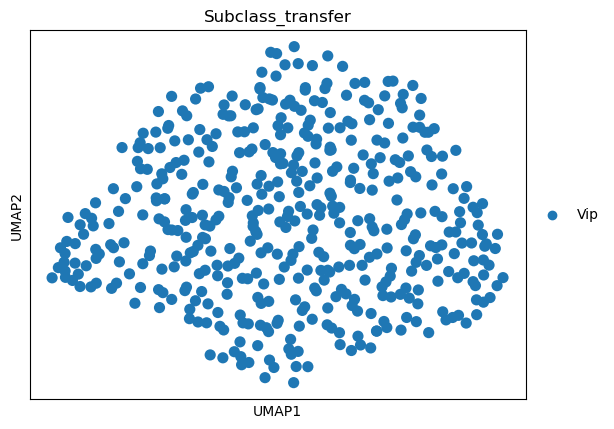

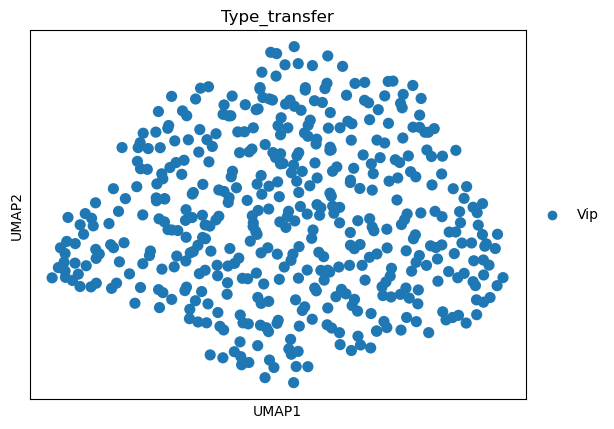

Integrating for partition p249


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 4950 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 2/2 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 165 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


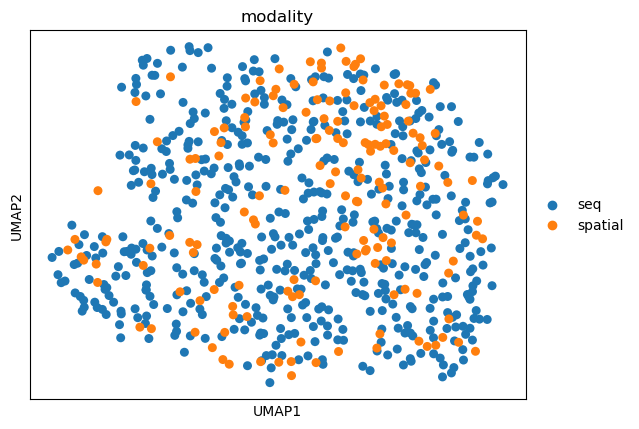

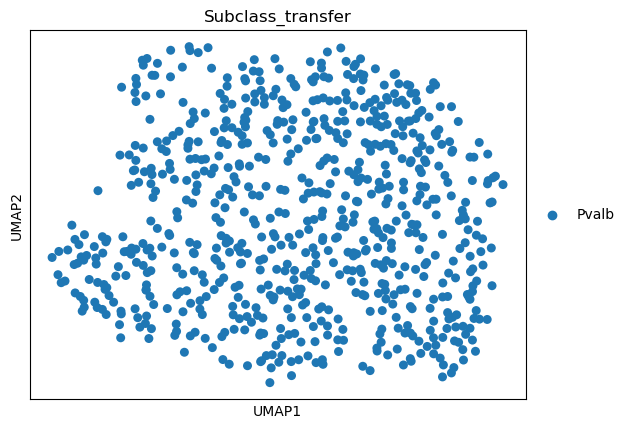

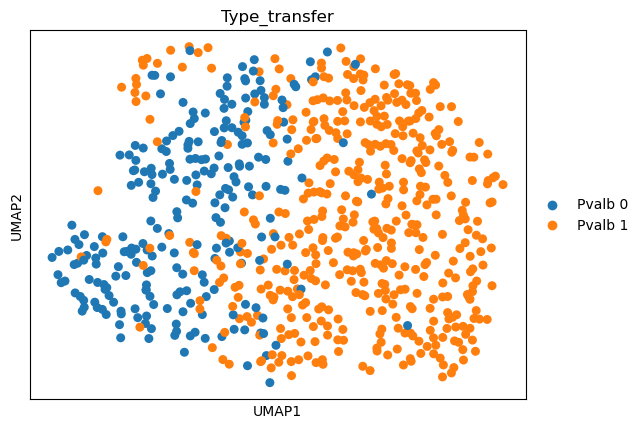

Integrating for partition p61


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 26026 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 3/3 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 868 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


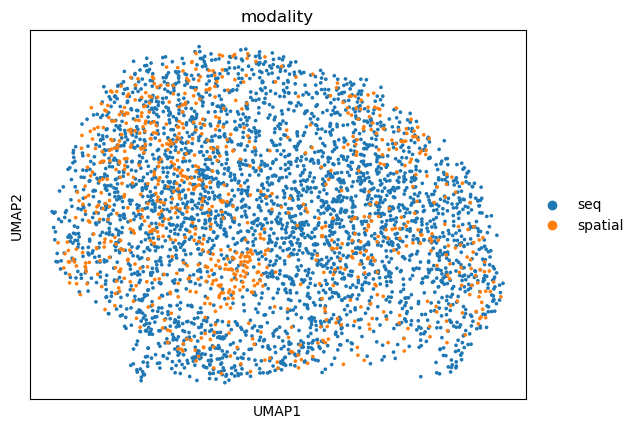

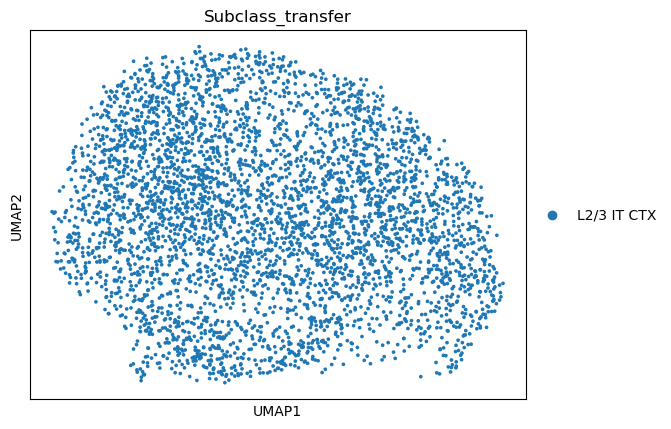

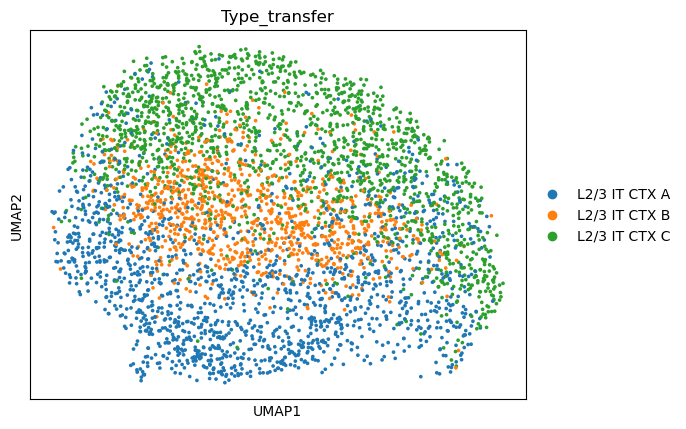

Integrating for partition p92


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 10800 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 4/4 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/ALLCools/integration/seurat_class.py:657: RuntimeWarning: invalid value encountered in divide
  D = (1 - D / D[:, -1][:, None]) * score[G]
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 360 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


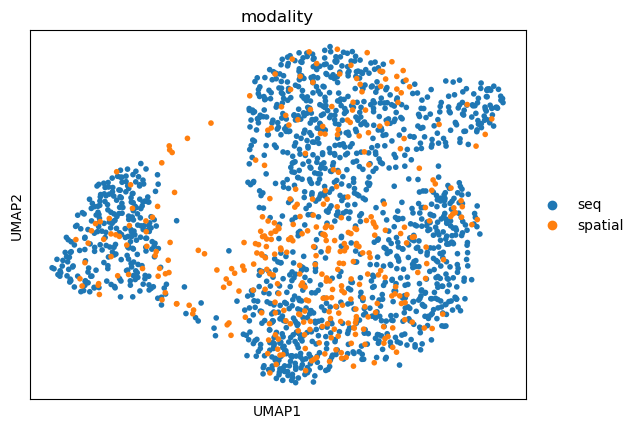

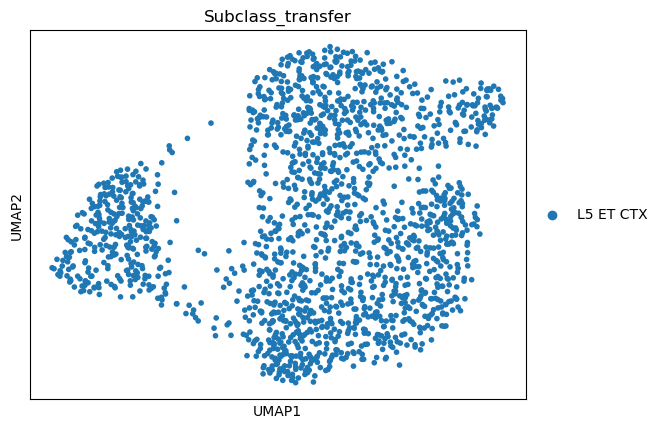

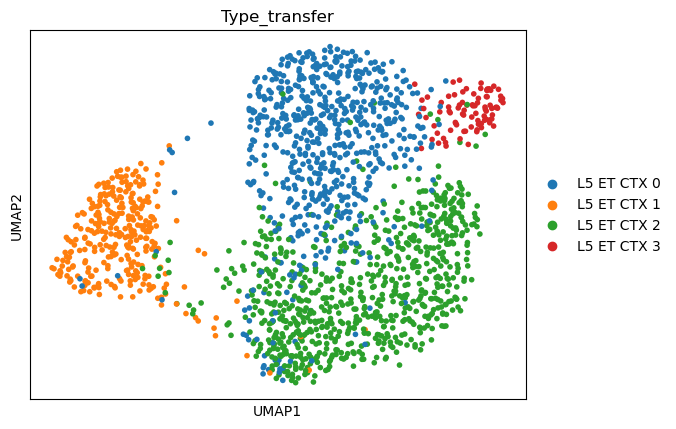

CPU times: user 55min 12s, sys: 3min 49s, total: 59min 1s
Wall time: 25min 23s


In [115]:

%%time
# 设置工作目录
workspace_path = '/mnt/f/spatial/V1_integration/NR2_2/'
partition_path = workspace_path + 'partitions/'
partitions = sorted(os.listdir(partition_path))

for pn in partitions:
    print(f'Integrating for partition {pn}')
    
    # 设置每个分区的文件路径
    integration_path = partition_path + pn + '/'
    input_adata_seq_file = os.path.join(integration_path, 'adata_seq.h5ad')
    input_adata_spatial_file = os.path.join(integration_path, 'adata_spatial_integrated.h5ad')
    
    # 检查文件是否存在
    if not (os.path.exists(input_adata_seq_file) and os.path.exists(input_adata_spatial_file)):
        print(f'Missing input files for partition {pn}. Skipping this integration.')
        continue  # 如果文件缺失，跳过此分区
    ## Load and preprocess the data
    adata_seq_raw = sc.read_h5ad(input_adata_seq_file)
    adata_seq = adata_seq_raw.copy()
    adata_spatial_raw = sc.read_h5ad(input_adata_spatial_file)
    adata_spatial = adata_spatial_raw.copy()

    # Consider the common genes
    common_genes = np.array(adata_seq.var_names.intersection(adata_spatial.var_names))
    #adata_seq._inplace_subset_var(common_genes)
    
    # Normalize
    sc.pp.normalize_total(adata_seq, target_sum=1000)
    sc.pp.log1p(adata_seq)
    sc.pp.normalize_total(adata_spatial, target_sum=1000)
    sc.pp.log1p(adata_spatial)
    
    # Select variable genes
    #sc.pp.highly_variable_genes(adata_seq)
    #hv_genes = list(adata_seq.var.index[adata_seq.var['dispersions'] > 0])
    #adata_seq = adata_seq[:, adata_seq.var.index.isin(hv_genes)]
    #adata_spatial = adata_spatial[:, adata_spatial.var.index.isin(hv_genes)]
    #print(f'Use {len(hv_genes)} highly variable genes for integration.')
    
    # Scale the data
    sc.pp.scale(adata_seq)
    sc.pp.scale(adata_spatial)
    
    # Merge the datasets
    adata_merge = adata_seq.concatenate(adata_spatial,
                                    batch_categories=['seq', 'spatial'],
                                    batch_key='modality',
                                    index_unique=None)
     # Select variable genes
    #sc.pp.highly_variable_genes(adata_merge)
    #target_genes=['Syt17','Stard8','Whrn','Rorb','Scnn1a','Syt2','Tle4','Syt6','Ccn2']
    #adata_merge.var['highly_variable'] = (
    #adata_merge.var['highly_variable'] | adata_merge.var_names.isin(target_genes))
    # PCA

    n_pcs = 30
    sc.tl.pca(adata_merge, svd_solver='arpack', n_comps=n_pcs)
    
    adata_list = [adata_merge[adata_merge.obs['modality'] == 'seq'],
                  adata_merge[adata_merge.obs['modality'] == 'spatial']]
    
    ## Integration
    # Find the integration anchors
    integrator = SeuratIntegration()
    integrator.find_anchor(adata_list,
                       k_local=None,
                       key_local='X_pca',
                       k_anchor=30,
                       key_anchor='X',
                       dim_red='cca',
                       max_cc_cells=100000,
                       k_score=100,
                       k_filter=None, #why?
                       scale1=False,
                       scale2=False,
                       n_components=n_pcs,
                       n_features=200,
                       alignments=[[[0], [1]]])
    
    # Label transfer
    cell_type_cols = ['Subclass', 'Type']
    transfer_results = integrator.label_transfer(
        ref=[0],
        qry=[1],
        categorical_key=cell_type_cols,
        key_dist='X_pca',
        k_weight=100,
        npc=n_pcs
    )
    integrator.save_transfer_results_to_adata(adata_merge, transfer_results)
    
    # Assign the transfered labels and the confidence
    for cell_type_col in cell_type_cols:
        adata_spatial_raw.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1
                                                                                           ).astype('category')
        adata_spatial_raw.obs[cell_type_col + '_confidence'] = transfer_results[cell_type_col].max(axis=1)
        
        n_transfered = len(np.unique(adata_spatial_raw.obs[cell_type_col + '_transfer']))
        n_total = len(np.unique(adata_merge.obs[cell_type_col + '_transfer']))
        print(f'Transfered {n_transfered}/{n_total} {cell_type_col}.')
    
    # Impute gene expression
    X_imputed = impute_gene_expression(integrator, adata_list, adata_seq_raw.X, 
                                       ref=0, qry=1, npc=n_pcs, chunk_size=5000)
    adata_imputed = anndata.AnnData(X=X_imputed, obs=adata_spatial_raw.obs.copy(), 
                                var=adata_seq_raw.var.copy(), dtype=np.float32)
    print(adata_imputed)

    # 创建一个具有与 `adata_spatial_raw` 相同维度的矩阵，初始值为 0
    imputed_data = np.zeros(adata_spatial_raw.shape)

    # 匹配并填充 `imputed_data` 中的基因表达数据
    for i, gene in enumerate(adata_imputed.var_names):
        if gene in adata_spatial_raw.var_names:
           idx = adata_spatial_raw.var_names.get_loc(gene)
           imputed_data[:, idx] = adata_imputed[:, i].X.toarray().flatten()

    # 将填充后的矩阵存储在 `layers` 中
    adata_spatial_raw.layers['imputed'] = imputed_data
    # Save the label transfer results
    adata_spatial_raw.write_h5ad(os.path.join(integration_path, 'adata_spatial_label_transfer.h5ad'), 
                                 compression='gzip')
    # Create the imputation gene partition table
    gene_partition_df = adata_seq_raw.var.copy()
    gene_partition_df.index.name = 'gene'
    gene_partition_df['gene_partition'] = np.arange(gene_partition_df.shape[0], dtype=int) // 1000
    gene_partition_df.to_csv(os.path.join(integration_path,f'/mnt/f/spatial/V1_integration/NR2_2/partitions/{pn}/gene_partition.csv'))
    
    gene_partitions = np.unique(gene_partition_df['gene_partition'])

    
    ## Co-embedding
    # Correct the PCs using the integration anchors
    corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=n_pcs,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

    adata_merge.obsm['X_pca_integrate'] = np.concatenate(corrected)
    
    # Calculate KNN using the integrated PCs
    sc.pp.neighbors(adata_merge, use_rep='X_pca_integrate')
    
    if len(np.unique(adata_merge.obs['Subclass_transfer'])) > 1:
        # Generate the PAGA plot for the initial arrangement of the UMAP
        sc.tl.paga(adata_merge, groups='Subclass_transfer')
        sc.pl.paga(adata_merge, save=f'{pn}_paga.png', cmap='gist_ncar')
    
        sc.tl.umap(adata_merge, init_pos='paga', min_dist=0.5)
    else:
        sc.tl.umap(adata_merge, min_dist=0.5)
        
    # Save the umap
    sc.pl.umap(adata_merge, color='modality', save=f'{pn}_umap_modality.png')
    sc.pl.umap(adata_merge, color='Subclass_transfer', save=f'{pn}_umap_subclass.png' )
    sc.pl.umap(adata_merge, color='Type_transfer', save=f'{pn}_umap_type.png')

    # 保存合并后的数据
    adata_merge.write_h5ad(os.path.join(integration_path, 'adata_merged_round2.h5ad'), compression='gzip')

Integrating for partition p239


<timed exec>:45: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 15
Find Anchors using k=17
Score Anchors
Identified 285 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph
AnnData object with n_obs × n_vars = 19 × 22105
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean'

/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


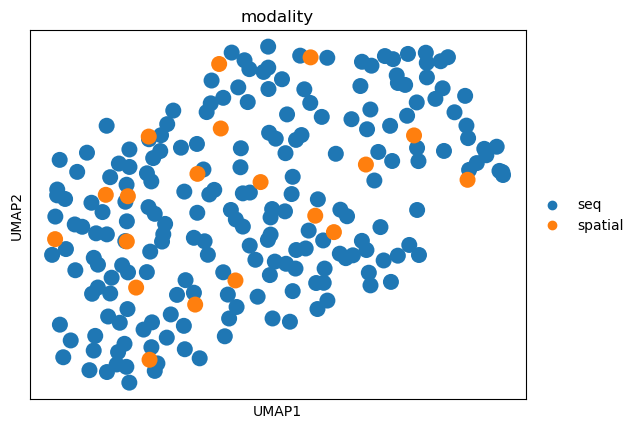

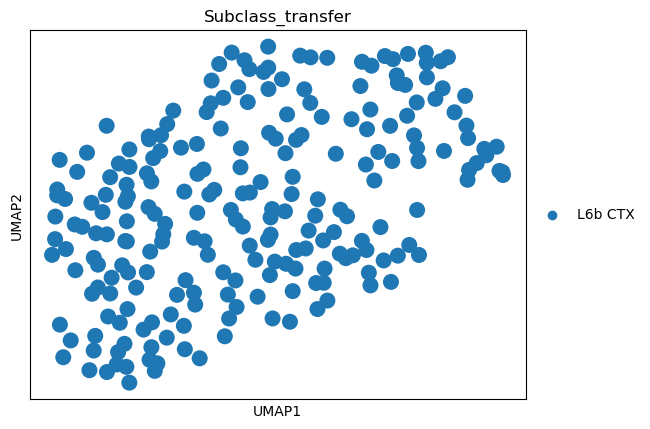

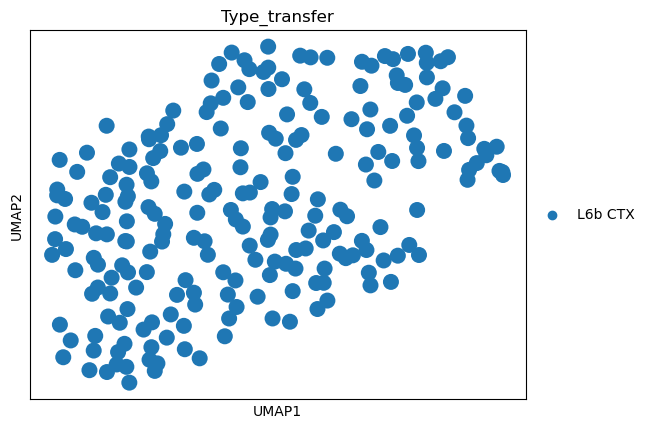

CPU times: user 54.1 s, sys: 616 ms, total: 54.7 s
Wall time: 46.1 s


In [119]:

%%time
# 设置工作目录
workspace_path = '/mnt/f/spatial/V1_integration/NR2_2/'
partition_path = workspace_path + 'partitions/'
partitions = ['p239']
for pn in partitions:
    print(f'Integrating for partition {pn}')
    
    # 设置每个分区的文件路径
    integration_path = partition_path + pn + '/'
    input_adata_seq_file = os.path.join(integration_path, 'adata_seq.h5ad')
    input_adata_spatial_file = os.path.join(integration_path, 'adata_spatial_integrated.h5ad')
    
    # 检查文件是否存在
    if not (os.path.exists(input_adata_seq_file) and os.path.exists(input_adata_spatial_file)):
        print(f'Missing input files for partition {pn}. Skipping this integration.')
        continue  # 如果文件缺失，跳过此分区
    ## Load and preprocess the data
    adata_seq_raw = sc.read_h5ad(input_adata_seq_file)
    adata_seq = adata_seq_raw.copy()
    adata_spatial_raw = sc.read_h5ad(input_adata_spatial_file)
    adata_spatial = adata_spatial_raw.copy()

    # Consider the common genes
    common_genes = np.array(adata_seq.var_names.intersection(adata_spatial.var_names))
    #adata_seq._inplace_subset_var(common_genes)
    
    # Normalize
    sc.pp.normalize_total(adata_seq, target_sum=1000)
    sc.pp.log1p(adata_seq)
    sc.pp.normalize_total(adata_spatial, target_sum=1000)
    sc.pp.log1p(adata_spatial)
    
    # Select variable genes
    #sc.pp.highly_variable_genes(adata_seq)
    #hv_genes = list(adata_seq.var.index[adata_seq.var['dispersions'] > 0])
    #adata_seq = adata_seq[:, adata_seq.var.index.isin(hv_genes)]
    #adata_spatial = adata_spatial[:, adata_spatial.var.index.isin(hv_genes)]
    #print(f'Use {len(hv_genes)} highly variable genes for integration.')
    
    # Scale the data
    sc.pp.scale(adata_seq)
    sc.pp.scale(adata_spatial)
    
    # Merge the datasets
    adata_merge = adata_seq.concatenate(adata_spatial,
                                    batch_categories=['seq', 'spatial'],
                                    batch_key='modality',
                                    index_unique=None)
     # Select variable genes
    #sc.pp.highly_variable_genes(adata_merge)
    #target_genes=['Syt17','Stard8','Whrn','Rorb','Scnn1a','Syt2','Tle4','Syt6','Ccn2']
    #adata_merge.var['highly_variable'] = (
    #adata_merge.var['highly_variable'] | adata_merge.var_names.isin(target_genes))
    # PCA

    n_pcs = 15
    sc.tl.pca(adata_merge, svd_solver='arpack', n_comps=n_pcs)
    
    adata_list = [adata_merge[adata_merge.obs['modality'] == 'seq'],
                  adata_merge[adata_merge.obs['modality'] == 'spatial']]
    
    ## Integration
    # Find the integration anchors
    integrator = SeuratIntegration()
    integrator.find_anchor(adata_list,
                       k_local=None,
                       key_local='X_pca',
                       k_anchor=15,
                       key_anchor='X',
                       dim_red='cca',
                       max_cc_cells=100000,
                       k_score=100,
                       k_filter=None, #why?
                       scale1=False,
                       scale2=False,
                       n_components=n_pcs,
                       n_features=200,
                       alignments=[[[0], [1]]])
    
    # Label transfer
    cell_type_cols = ['Subclass', 'Type']
    transfer_results = integrator.label_transfer(
        ref=[0],
        qry=[1],
        categorical_key=cell_type_cols,
        key_dist='X_pca',
        k_weight=100,
        npc=n_pcs
    )
    integrator.save_transfer_results_to_adata(adata_merge, transfer_results)
    
    # Assign the transfered labels and the confidence
    for cell_type_col in cell_type_cols:
        adata_spatial_raw.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1
                                                                                           ).astype('category')
        adata_spatial_raw.obs[cell_type_col + '_confidence'] = transfer_results[cell_type_col].max(axis=1)
        
        n_transfered = len(np.unique(adata_spatial_raw.obs[cell_type_col + '_transfer']))
        n_total = len(np.unique(adata_merge.obs[cell_type_col + '_transfer']))
        print(f'Transfered {n_transfered}/{n_total} {cell_type_col}.')
    
    # Impute gene expression
    X_imputed = impute_gene_expression(integrator, adata_list, adata_seq_raw.X, 
                                       ref=0, qry=1, npc=n_pcs, chunk_size=5000)
    adata_imputed = anndata.AnnData(X=X_imputed, obs=adata_spatial_raw.obs.copy(), 
                                var=adata_seq_raw.var.copy(), dtype=np.float32)
    print(adata_imputed)

    # 创建一个具有与 `adata_spatial_raw` 相同维度的矩阵，初始值为 0
    imputed_data = np.zeros(adata_spatial_raw.shape)

    # 匹配并填充 `imputed_data` 中的基因表达数据
    for i, gene in enumerate(adata_imputed.var_names):
        if gene in adata_spatial_raw.var_names:
           idx = adata_spatial_raw.var_names.get_loc(gene)
           imputed_data[:, idx] = adata_imputed[:, i].X.toarray().flatten()

    # 将填充后的矩阵存储在 `layers` 中
    adata_spatial_raw.layers['imputed'] = imputed_data
    # Save the label transfer results
    adata_spatial_raw.write_h5ad(os.path.join(integration_path, 'adata_spatial_label_transfer.h5ad'), 
                                 compression='gzip')
    # Create the imputation gene partition table
    gene_partition_df = adata_seq_raw.var.copy()
    gene_partition_df.index.name = 'gene'
    gene_partition_df['gene_partition'] = np.arange(gene_partition_df.shape[0], dtype=int) // 1000
    gene_partition_df.to_csv(os.path.join(integration_path,f'/mnt/f/spatial/V1_integration/NR2_2/partitions/{pn}/gene_partition.csv'))
    
    gene_partitions = np.unique(gene_partition_df['gene_partition'])

    
    ## Co-embedding
    # Correct the PCs using the integration anchors
    corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=n_pcs,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

    adata_merge.obsm['X_pca_integrate'] = np.concatenate(corrected)
    
    # Calculate KNN using the integrated PCs
    sc.pp.neighbors(adata_merge, use_rep='X_pca_integrate')
    
    if len(np.unique(adata_merge.obs['Subclass_transfer'])) > 1:
        # Generate the PAGA plot for the initial arrangement of the UMAP
        sc.tl.paga(adata_merge, groups='Subclass_transfer')
        sc.pl.paga(adata_merge, save=f'{pn}_paga.png', cmap='gist_ncar')
    
        sc.tl.umap(adata_merge, init_pos='paga', min_dist=0.5)
    else:
        sc.tl.umap(adata_merge, min_dist=0.5)
        
    # Save the umap
    sc.pl.umap(adata_merge, color='modality', save=f'{pn}_umap_modality.png')
    sc.pl.umap(adata_merge, color='Subclass_transfer', save=f'{pn}_umap_subclass.png' )
    sc.pl.umap(adata_merge, color='Type_transfer', save=f'{pn}_umap_type.png')

    # 保存合并后的数据
    adata_merge.write_h5ad(os.path.join(integration_path, 'adata_merged_round2.h5ad'), compression='gzip')

In [120]:
import scipy.sparse
import scipy.spatial

def get_cluster_mean_expression_matrix(adata, cluster_column):
    '''Get a dataframe of mean gene expression of each cluster.'''
    if scipy.sparse.issparse(adata.X):
        X = adata.X.toarray()
    else:
        X = adata.X
   
    cell_exp_mtx = pd.DataFrame(X, index=adata.obs[cluster_column], columns=adata.var.index)    
    return cell_exp_mtx.groupby(by=cluster_column).mean()


def calc_cell_cosines_to_cluster_mean_exps(adata, cluster_col, cluster_mean_exp_df):
    cluster_mean_exp_df = cluster_mean_exp_df.loc[:, adata.var.index]
    cluster_id_map = {cluster_mean_exp_df.index[i]:i for i in range(cluster_mean_exp_df.shape[0])}
    cell_cluster_ids = np.array(adata.obs[cluster_col].map(cluster_id_map))
    
    X_cluster_mean = cluster_mean_exp_df.values[cell_cluster_ids]
    
    if scipy.sparse.issparse(adata.X):
        X = adata.X.toarray()
    else:
        X = adata.X
    
    cosines = []
    for i in range(adata.shape[0]):
        if np.sum(X[i]) > 0:
            cosines.append(1 - scipy.spatial.distance.cosine(X[i], X_cluster_mean[i]))
        else:
            cosines.append(0)
    
    return cosines

In [140]:
# Combine the label transfer results

partition_path = '/mnt/f/spatial/V1_integration/NR2_2/partitions'
partitions = sorted(os.listdir(partition_path))
adatas = []
for pn in partitions:
    adata_file = os.path.join(partition_path, pn, 'adata_spatial_label_transfer.h5ad')
    adatas.append(sc.read_h5ad(adata_file))
    
adata = anndata.concat(adatas)
adata.write_h5ad('/mnt/f/spatial/V1_integration/NR2_2/spatial_tranfer_11.h5ad')

In [141]:
# Combine the merged data
partition_path = '/mnt/f/spatial/V1_integration/NR2_2/partitions'
partitions = sorted(os.listdir(partition_path))
adatas = []
for pn in partitions:
    adata_file = os.path.join(partition_path, pn, 'adata_merged_round2.h5ad')
    adatas.append(sc.read_h5ad(adata_file))
    
adata_merged2 = anndata.concat(adatas)
adata_merged2.write_h5ad('/mnt/f/spatial/V1_integration/NR2_2/spatial_merged_round2_30.h5ad')

In [ ]:
adata_merged2=sc.read_h5ad('/mnt/f/spatial/V1_integration/NR2_2/spatial_merged_round2_30.h5ad')

In [4]:
adata=sc.read_h5ad('/mnt/f/spatial/V1_integration/NR2_2/spatial_tranfer_11.h5ad')

In [3]:
all_spatial = pd.read_csv('/mnt/f/spatial/V1_integration/cortex/NR2_2_cortex.csv',index_col='cell_id')

In [5]:
adata

AnnData object with n_obs × n_vars = 4649 × 25508
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    obsm: 'stereo'
    layers: 'imputed'

In [40]:
all_spatial

orig.ident  nCount_Spatial  nFeature_Spatial      area  coor_x  \
cell_id                                                                  
76809      Spatial             436               256  VISpm-L6   12253   
76812      Spatial             661               366  VISpm-L6   12284   
76813      Spatial             920               443  VISpm-L6   12284   
76852      Spatial             816               441  VISpm-L6   12264   
76853      Spatial             469               271  VISpm-L6   12263   
...            ...             ...               ...       ...     ...   
117075     Spatial             253               148    AUD-L1   18954   
117076     Spatial             160               101    AUD-L1   18955   
117078     Spatial             111                81    AUD-L1   18960   
117079     Spatial             146                80    AUD-L1   18965   
117080     Spatial             253               149    AUD-L1   18969   

         coor_y areaL1    coor_x_ad     coor_y_ad left_right  \
cell_id                                                        
76809     20398    V2M  10031.61544  11700.455670      right   
76812     20446    V2M  10060.92138  11749.508320      right   
76813     20476    V2M  10059.87439  11779.490040      right   
76852     20598    V2M  10035.62884  11900.717730      right   
76853     20567    V2M  10035.71133  11869.701720      right   
...         ...    ...          ...           ...        ...   
117075    16422    AUD  16867.29377   7960.739273      right   
117076    16463    AUD  16866.86228   8001.749196      right   
117078    16479    AUD  16871.30084   8017.913947      right   
117079    16447    AUD  16877.41458   7986.107938      right   
117080    16400    AUD  16883.05242   7939.276167      right   

         cluster_img_label  digital_layer  digital_column  
cell_id                                                    
76809                    8       8.750000       10.000000  
76812                    8       8.699378        9.977770  
76813                    8       8.431154        9.969369  
76852                    8       7.750000       10.000000  
76853                    8       8.000000       10.000000  
...                    ...            ...             ...  
117075                   1       1.249005        4.642147  
117076                   1       1.201550        4.673807  
117078                   1       1.201550        4.673807  
117079                   1       1.249005        4.642147  
117080                   1       1.282538        4.610737  

[15453 rows x 13 columns]

In [20]:
adata_density = adata.obs

In [6]:
all_spatial_index = all_spatial.index.astype(str)

In [21]:
adata_index =adata_density.index.astype(str)

In [22]:
adata_index

Index(['80500', '80512', '80513', '80518', '80526', '80528', '80529', '80533',
       '80534', '80535',
       ...
       '102447', '102507', '102542', '102568', '103879', '103880', '103932',
       '103952', '105183', '105240'],
      dtype='object', length=4649)

In [23]:
common_index  =all_spatial_index.intersection(adata_index)

In [24]:
common_index

Index(['80474', '80476', '80477', '80481', '80484', '80485', '80487', '80488',
       '80490', '80500',
       ...
       '105246', '105247', '105248', '105249', '105250', '105251', '105252',
       '105253', '106647', '106650'],
      dtype='object', length=4649)

In [16]:
common_index =common_index.astype(str)

In [17]:
common_index

Index(['80474', '80476', '80477', '80481', '80484', '80485', '80487', '80488',
       '80490', '80500',
       ...
       '105246', '105247', '105248', '105249', '105250', '105251', '105252',
       '105253', '106647', '106650'],
      dtype='object', length=4649)

In [25]:
all_spatial.index = all_spatial.index.astype(str)

In [26]:
spatial_common = all_spatial.loc[all_spatial.index.intersection(common_index)]

In [27]:
spatial_common

orig.ident  nCount_Spatial  nFeature_Spatial     area  coor_x  coor_y  \
80474     Spatial             383               235  VISp-L6   12715   19956   
80476     Spatial             263               176  VISp-L6   12719   19894   
80477     Spatial             240               163  VISp-L6   12724   19914   
80481     Spatial             246               166  VISp-L6   12733   19948   
80484     Spatial             449               261  VISp-L6   12749   19967   
...           ...             ...               ...      ...     ...     ...   
105251    Spatial             293               143  VISp-L1   16298   20278   
105252    Spatial             120                61  VISp-L1   16327   20252   
105253    Spatial              59                30  VISp-L1   16343   20237   
106647    Spatial             214                87  VISp-L1   16386   20188   
106650    Spatial             202               104  VISp-L1   16411   20167   

       areaL1    coor_x_ad    coor_y_ad left_right  cluster_img_label  \
80474      V1  10508.75958  11274.84850      right                  6   
80476      V1  10514.92091  11213.02586      right                  6   
80477      V1  10519.21987  11233.18818      right                  6   
80481      V1  10527.02781  11267.48156      right                  6   
80484      V1  10542.35497  11287.02838      right                  6   
...       ...          ...          ...        ...                ...   
105251     V1  14078.33927  11721.69724      right                  6   
105252     V1  14108.22899  11696.72516      right                  6   
105253     V1  14124.74274  11682.29269      right                  6   
106647     V1  14169.42662  11634.82322      right                  6   
106650     V1  14195.14428  11614.70850      right                  6   

        digital_layer  digital_column  
80474        9.826572        9.617741  
80476       10.000000        9.617925  
80477       10.000000        9.617925  
80481        9.826572        9.617741  
80484        9.826572        9.617741  
...               ...             ...  
105251       1.000000        7.293706  
105252       1.000000        7.262238  
105253       1.000000        7.262238  
106647       1.000000        7.230769  
106650       1.000000        7.230769  

[4649 rows x 13 columns]

In [28]:
adata.obs['digital_layer']=spatial_common['digital_layer']

In [29]:
adata

AnnData object with n_obs × n_vars = 4649 × 25508
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence', 'digital_layer'
    obsm: 'stereo'
    layers: 'imputed'

In [32]:
adata.write_h5ad('/mnt/f/spatial/V1_integration/NR2_2/spatial_tranfer_digital_layer_11.h5ad')

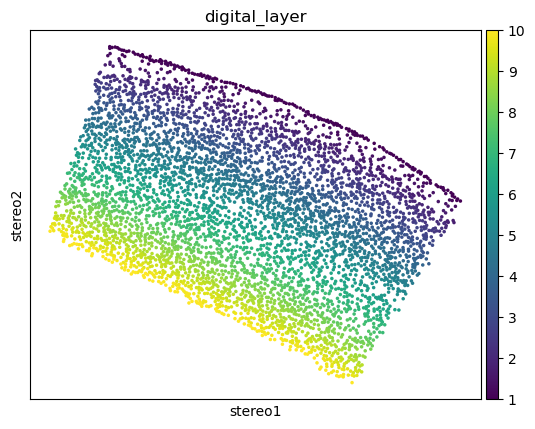

In [30]:
sc.pl.embedding(adata, basis='stereo',color='digital_layer',alpha=None)

In [166]:
adata_it =adata[adata.obs['Subclass_transfer']!='Astro'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Microglia'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='OPC'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Oligo'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Pvalb'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Sst'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Vip'] 

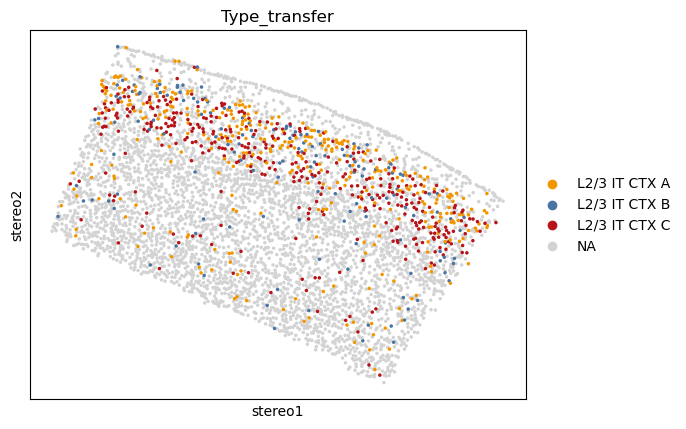

In [172]:
sc.pl.embedding(adata,basis='stereo',color=['Type_transfer'],groups=['L2/3 IT CTX A','L2/3 IT CTX B','L2/3 IT CTX C'],palette=["#b81316","#f29600","#4974a4"])

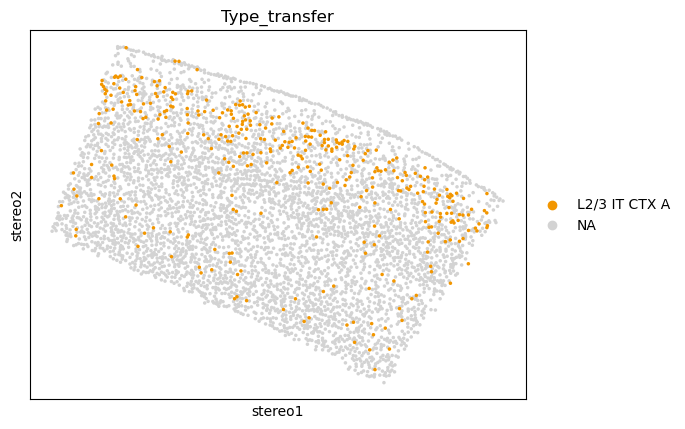

In [173]:
sc.pl.embedding(adata,basis='stereo',color=['Type_transfer'],groups=['L2/3 IT CTX A'])

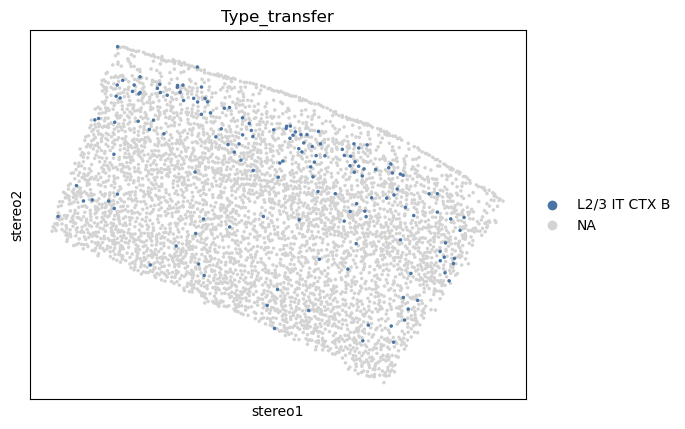

In [174]:
sc.pl.embedding(adata,basis='stereo',color=['Type_transfer'],groups=['L2/3 IT CTX B'])

In [1]:
sc.pl.embedding(adata,basis='stereo',color=['Type_transfer'],groups=['L2/3 IT CTX C'])

NameError: name 'sc' is not defined

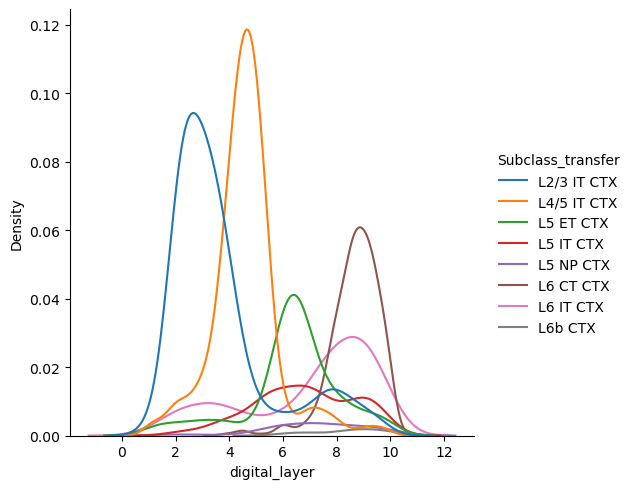

In [167]:
sns.displot(data=adata_it.obs, x='digital_layer',hue="Subclass_transfer",kind='kde')

In [168]:
adata_l23 = adata[adata.obs['Subclass_transfer']=='L2/3 IT CTX']

/root/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


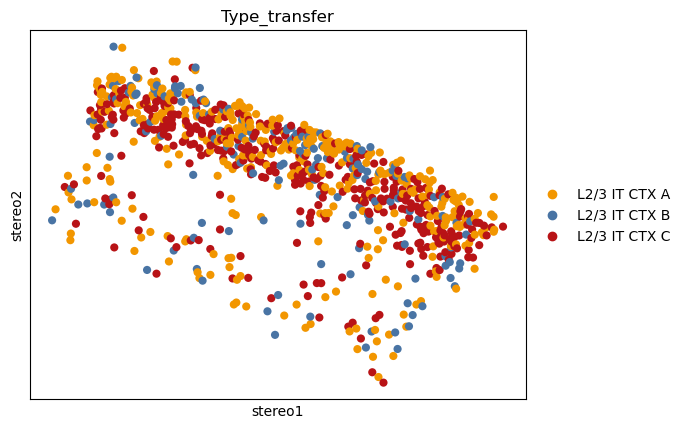

In [169]:
sc.pl.embedding(adata_l23,basis='stereo',color=['Type_transfer'],groups=['L2/3 IT CTX A','L2/3 IT CTX B','L2/3 IT CTX C'],palette=["#f29600","#4974a4","#b81316"])

(0.0, 5.5)

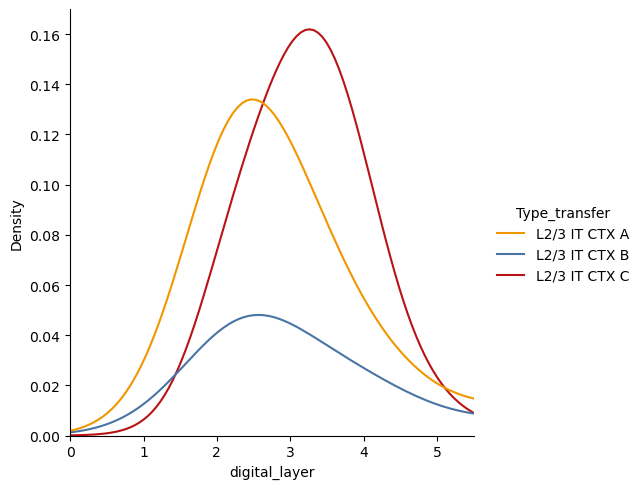

In [170]:
sns.displot(data=adata_l23.obs, x="digital_layer",hue="Type_transfer",kind='kde',palette=["#f29600","#4974a4","#b81316"])
plt.xlim(0,5.5)

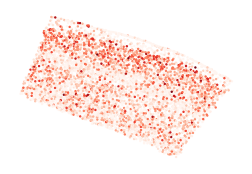

In [171]:
# 确定目标基因
target_gene = 'Syt17'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

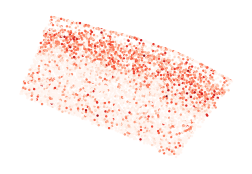

In [176]:
# 确定目标基因
target_gene = 'Stard8'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

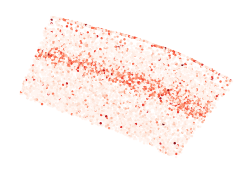

In [177]:
# 确定目标基因
target_gene = 'Whrn'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

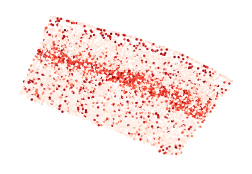

In [178]:
# 确定目标基因
target_gene = 'Rorb'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

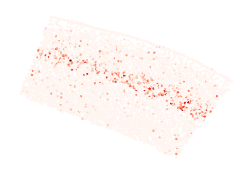

In [179]:
# 确定目标基因
target_gene = 'Scnn1a'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

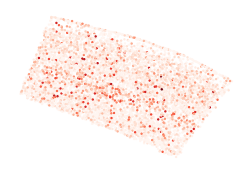

In [180]:
# 确定目标基因
target_gene = 'Syt2'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

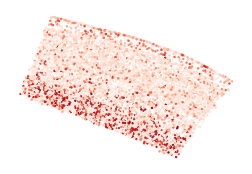

In [181]:
# 确定目标基因
target_gene = 'Tle4'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

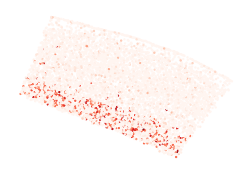

In [182]:
# 确定目标基因
target_gene = 'Syt6'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

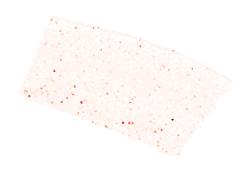

In [184]:
# 确定目标基因
target_gene = 'Cplx3'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    #plt.colorbar(label= 'Expression (Z-score)')
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

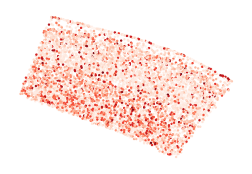

In [185]:
# 确定目标基因
target_gene = 'Cdh13'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    #plt.colorbar(label= 'Expression (Z-score)')
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

In [186]:
adata_itl23= adata_it[adata_it.obs['Subclass_transfer']=='L2/3 IT CTX']

In [187]:
adata_l23 = adata_itl23[adata_itl23.obs['digital_layer'].between(1, 5.5)]

In [188]:
adata_l23.obs['Subclass_transfer']

82706     L2/3 IT CTX
82709     L2/3 IT CTX
82745     L2/3 IT CTX
82748     L2/3 IT CTX
82750     L2/3 IT CTX
             ...     
105221    L2/3 IT CTX
105223    L2/3 IT CTX
105227    L2/3 IT CTX
105228    L2/3 IT CTX
105250    L2/3 IT CTX
Name: Subclass_transfer, Length: 741, dtype: category
Categories (1, object): ['L2/3 IT CTX']

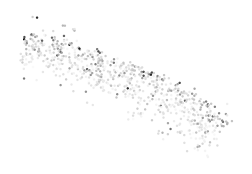

In [189]:
# 确定目标基因
target_gene = 'Cdh13'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata_l23.var_names:
    # 获取坐标信息
    x = adata_l23.obs['coor_x_ad']
    y = adata_l23.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata_l23[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Greys', s=0.5)
    #plt.colorbar(label= 'Expression (Z-score)')
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

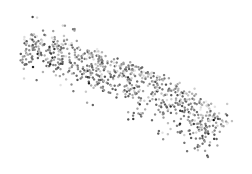

In [192]:
# 确定目标基因
target_gene = 'Igsf9b'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata_l23.var_names:
    # 获取坐标信息
    x = adata_l23.obs['coor_x_ad']
    y = adata_l23.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata_l23[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(3, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Greys', s=0.5)
    #plt.colorbar(label= 'Expression (Z-score)')
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

In [ ]:
NR_V1_spatial = NR_V1_merge[NR_V1_merge.obs['modality']=='spatial']

sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L2/3 IT CTX'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='L2/3 IT CTX'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L4/5 IT CTX'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='L4/5 IT CTX'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L5 IT CTX'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='L5 IT CTX'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L6 IT CTX'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='L6 IT CTX'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L5 NP CTX'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='L5 NP CTX'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L5 ET CTX'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='L5 ET CTX'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L6 CT CTX'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='L6 CT CTX'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L6b CTX'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='L6b CTX'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Sst'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='Sst'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['ABC'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='ABC'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Astro'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='Astro'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Pvalb'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='Pvalb'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['VLMC'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='VLMC'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['OPC'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='OPC'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Microglia'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='Microglia'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Vip'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='Vip'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Lamp5'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='Lamp5'])
sc.pl.embedding(NR_V1_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Oligo'],palette=["#b81316"])
print(NR_V1_spatial[NR_V1_spatial.obs['integration_subclass_transfer']=='Oligo'])